REINFORCE clean, updated implementation

In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

from dataclasses import dataclass, asdict

import plot

import modal

In [2]:
class SessionTracker():
    def __init__(self, n_timesteps, print_interval=None, window_length=64):
        self.current_timestep = 0
        self.n_timesteps = n_timesteps
        self.print_interval = print_interval
        self.window_length = window_length

        self.all_returns = []
        self.all_lengths = []

    def session_complete(self):
        return self.current_timestep >= self.n_timesteps

    def increment_timestep(self, n=1):
        previous_timestep = self.current_timestep

        self.current_timestep += n

        if self.print_interval and\
            previous_timestep // self.print_interval != self.current_timestep // self.print_interval:
            print(f"Current timestep: {self.current_timestep}, "
                  f"recent mean: {np.mean(self.all_returns[-self.window_length:]):.2f}, "
                  f"recent length: {np.mean(self.all_lengths[-self.window_length:]):.2f}, "
                  f"(window: {self.window_length})")

        return self.session_complete()
    
    def log_finished_episode(self, episode_return, episode_length):
        self.all_returns.append(episode_return)
        self.all_lengths.append(episode_length)

In [3]:
class ReinforceAgent(nn.Module):
    def __init__(self, state_space, action_space, hidden_size=64):
        super(ReinforceAgent, self).__init__()
        self.state_space = state_space
        self.action_space = action_space
        self.fc1 = nn.Linear(state_space, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_space) # Output logits for action probabilities
    
    def forward(self, state):
        x = torch.relu(self.fc1(state))
        # The output of fc2 are "logits" - raw scores that will be turned into probabilities
        logits = self.fc2(x) 
        return logits
    
    def get_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        
        # Get the raw output from the network (logits)
        logits = self.forward(state)
        
        # Turn logits into probabilities and create a distribution
        # Categorical is useful for discrete action spaces (like Lunar Lander)
        action_distribution = Categorical(logits=logits)
        
        # Sample an action from the distribution
        action = action_distribution.sample()
        
        # Get the log probability of the chosen action
        log_prob = action_distribution.log_prob(action)
        
        # Return the action (as a plain number) and its log-probability (as a PyTorch tensor)
        return action.item(), log_prob

In [4]:
@dataclass
class ReinforceParams:
    gamma: float            = 0.99
    normalize_returns: bool = True
    lr: float               = 0.001

In [5]:
# one 'rollout' is an episode
def collect_data_for_rollout(env, agent, tracker):
    log_probs = []
    rewards = []

    state, _ = env.reset()

    while not tracker.session_complete():
        tracker.increment_timestep()

        action, log_prob = agent.get_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        
        log_probs.append(log_prob)
        rewards.append(reward)
        
        state = next_state
        
        if terminated or truncated:
            episode_return = info['episode']['r']
            episode_length = info['episode']['l']

            tracker.log_finished_episode(episode_return, episode_length)
            break
    
    return log_probs, rewards

In [6]:
def calculate_returns(rewards, gamma=0.99, normalize_returns=True):
    returns = []
    
    future_return = 0
    for reward in reversed(rewards):
        future_return = reward + gamma * future_return
        returns.insert(0, future_return)
    
    returns = torch.tensor(returns)

    if normalize_returns:
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)

    return returns

In [7]:
def train_reinforce(agent, env_name, n_timesteps=100000, params=None):
    if params is None:
        params = ReinforceParams()

    tracker = SessionTracker(n_timesteps=n_timesteps, print_interval=10000, window_length=64)

    env = gym.make(env_name)
    env = gym.wrappers.RecordEpisodeStatistics(env)

    optimizer = optim.Adam(agent.parameters(), lr=params.lr)

    while not tracker.session_complete():
        log_probs, rewards = collect_data_for_rollout(env, agent, tracker)

        returns = calculate_returns(rewards, gamma=params.gamma, normalize_returns=params.normalize_returns)
        
        log_probs = torch.cat(log_probs)
        policy_loss = - (log_probs * returns).sum()

        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

    env.close()

    return tracker.all_returns, tracker.all_lengths

In [8]:
env_name = 'CartPole-v1'
n_timesteps = 100000
params = ReinforceParams(gamma=0.99, normalize_returns=True, lr=0.001)

agent = ReinforceAgent(state_space=gym.make(env_name).observation_space.shape[0],
                          action_space=gym.make(env_name).action_space.n)

returns, lengths = train_reinforce(agent, env_name, n_timesteps=n_timesteps, params=params)

Current timestep: 10000, recent mean: 55.05, recent length: 55.05, (window: 64)
Current timestep: 20000, recent mean: 124.66, recent length: 124.66, (window: 64)
Current timestep: 30000, recent mean: 173.05, recent length: 173.05, (window: 64)
Current timestep: 40000, recent mean: 208.00, recent length: 208.00, (window: 64)
Current timestep: 50000, recent mean: 179.94, recent length: 179.94, (window: 64)
Current timestep: 60000, recent mean: 252.58, recent length: 252.58, (window: 64)
Current timestep: 70000, recent mean: 314.36, recent length: 314.36, (window: 64)
Current timestep: 80000, recent mean: 348.59, recent length: 348.59, (window: 64)
Current timestep: 90000, recent mean: 384.59, recent length: 384.59, (window: 64)
Current timestep: 100000, recent mean: 397.47, recent length: 397.47, (window: 64)


(594,) (594,)


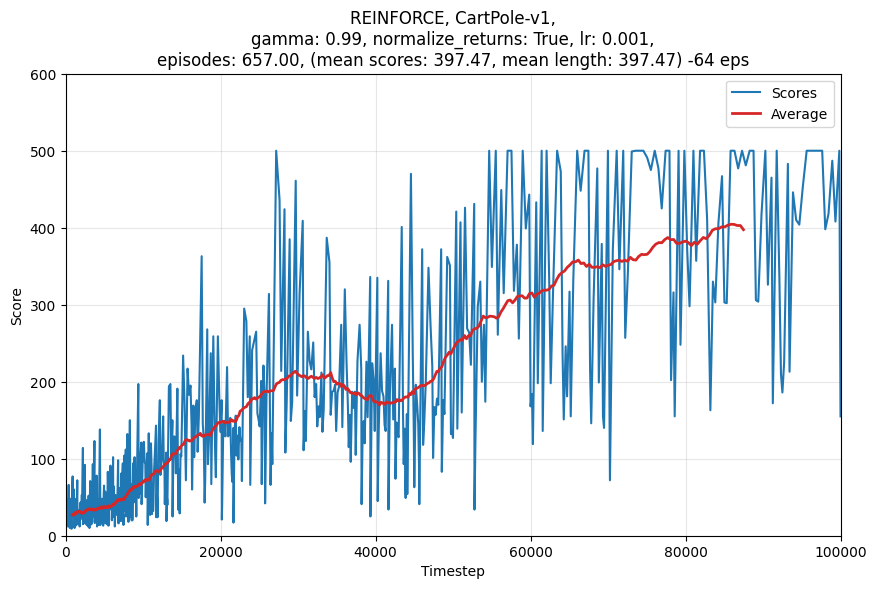

In [9]:
plot.plot_session(returns, lengths, 'REINFORCE', env_name, n_timesteps, params=asdict(params))

you'll need a Modal account to run this next lot of code, which runs the same thing many times.

it's free to sign up and run code.

In [ ]:
app = modal.App(name='rl')

image = modal.Image.debian_slim()\
    .apt_install('swig', 'build-essential')\
        .pip_install("gymnasium", "torch", "gymnasium[box2d]", "numpy", "stable_baselines3")

In [ ]:
@app.function(image=image, timeout=3600)
def modal_train_reinforce(env_name, n_timesteps, params=None):
    agent = ReinforceAgent(state_space=gym.make(env_name).observation_space.shape[0],
                          action_space=gym.make(env_name).action_space.n)
    
    returns, lengths = train_reinforce(
        agent, env_name, n_timesteps=n_timesteps, params=params)
    return returns, lengths

In [ ]:
n_sessions = 16
env_name = 'CartPole-v1'
n_timesteps = 100000
params = ReinforceParams(gamma=0.99, normalize_returns=False, lr=0.001)

with app.run():
    calls = [modal_train_reinforce.spawn(
        env_name=env_name, n_timesteps=n_timesteps, params=params)
        for i in range(n_sessions)]

    results = modal.FunctionCall.gather(*calls)

In [ ]:
plot.plot_sessions(results, 'REINFORCE', env_name, n_timesteps, params=asdict(params))